In [9]:
from pathlib import Path
import copy
from tqdm import tqdm

import torch
import pyscf
import numpy as np
import opt_einsum as oe

from cadft.utils import Grid
from cadft import CC_DFT_DATA, Mol


In [15]:
molecular = copy.deepcopy(Mol["Acetylene"])
molecular[0][1] += 0

dft2cc = CC_DFT_DATA(
    molecular,
    name="test",
    basis="STO-3G",
    if_basis_str=True,
)

mf = pyscf.scf.RHF(dft2cc.mol)
mf.kernel()
mycc = pyscf.cc.CCSD(mf)
mycc.kernel()
dm1_cc = mycc.make_rdm1(ao_repr=True)
dm2_cc = mycc.make_rdm2(ao_repr=True)
e_cc = mycc.e_tot

mdft = pyscf.scf.RKS(dft2cc.mol)
mdft.xc = "b3lyp"
mdft.kernel()
e_dft = mdft.e_tot
dm1_dft = mdft.make_rdm1(ao_repr=True)

grids = Grid(dft2cc.mol)
coords = grids.coords
weights = grids.weights
ao_2 = pyscf.dft.numint.eval_ao(dft2cc.mol, coords, deriv=2)
ao_0 = ao_2[0, :, :]
ao_value = ao_2[:4, :, :]
ao_2_diag = ao_2[4, :, :] + ao_2[7, :, :] + ao_2[9, :, :]

rho_dft = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_dft, xctype="GGA")
rho_cc = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_cc, xctype="GGA")

rho_dft_grids = grids.vector_to_matrix(rho_dft[0])
rho_cc_grids = grids.vector_to_matrix(rho_cc[0])

[['C', -0.605, -0.0, -0.0], ['C', 0.605, -0.0, 0.0], ['H', -1.677, 0.0, -0.0], ['H', 1.677, -0.0, 0.0]]


600


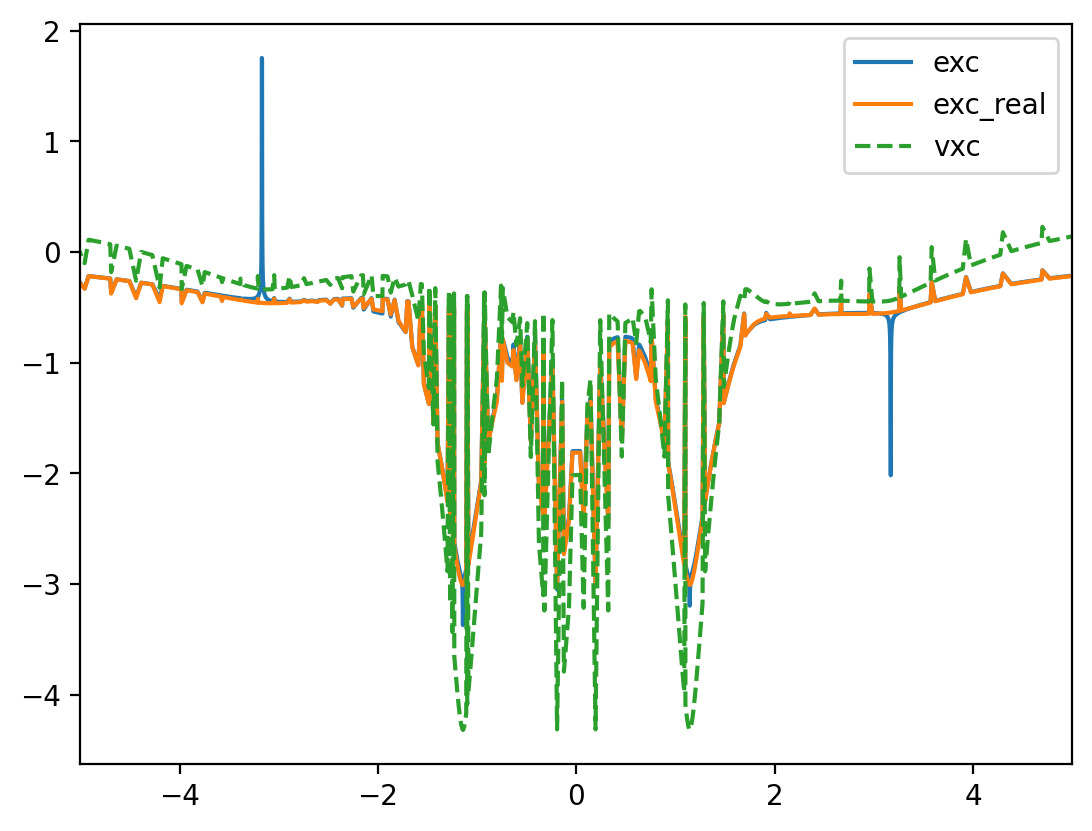

In [17]:
data = np.load("data/grids_mrks/data_Acetylene_cc-pcvtz_0_1_0.5000.npz")
exc_real = data["exc_real"]
exc = data["exc"]
vxc = data["vxc"]

index_ = np.where((np.abs(coords[:, 1]) < 1e-10) & (np.abs(coords[:, 2]) < 1e-10))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y11 = (grids.matrix_to_vector(exc))[index_][sort_]
y12 = (grids.matrix_to_vector(exc_real))[index_][sort_]
y2 = (grids.matrix_to_vector(vxc))[index_][sort_]

plt.plot(x, y11, label="exc")
plt.plot(x, y12, label="exc_real")
plt.plot(x, y2, label="vxc", linestyle="--")
plt.xlim(-5, 5)
# plt.ylim(-5, 2.5)
# plt.xlim(1.13, 1.155)

plt.legend(loc="best")
print(len(x))

7500


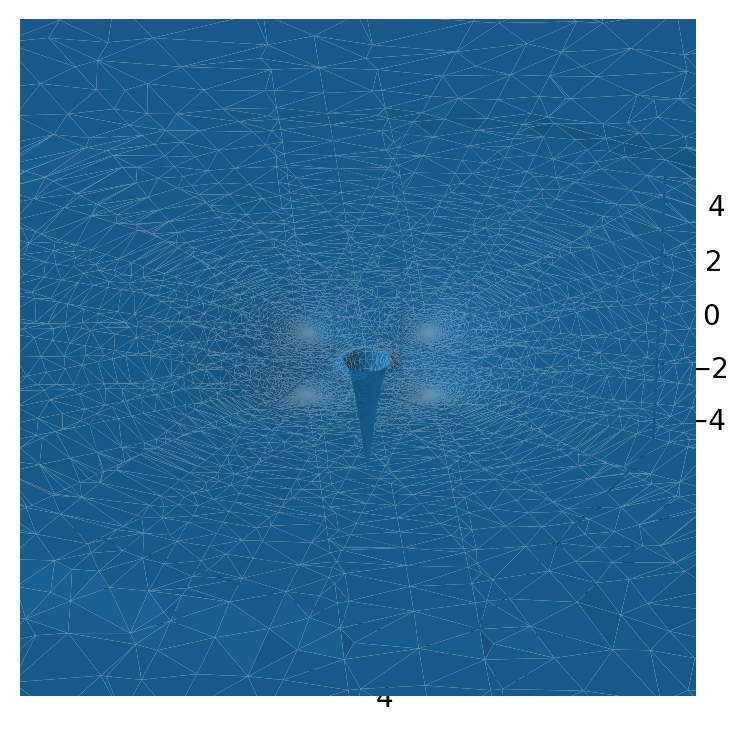

In [14]:
index_ = np.where((np.abs(coords[:, 2]) < 1e-10))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y = coords[:, 1][index_][sort_]
z11 = (grids.matrix_to_vector(exc))[index_][sort_]
z12 = (grids.matrix_to_vector(exc_real))[index_][sort_]
z2 = (grids.matrix_to_vector(vxc))[index_][sort_]

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
# ax.plot_trisurf(x, y, z11, label="exc")
# ax.plot_trisurf(x, y, z12, label="exc_real")
ax.plot_trisurf(x, y, z2, label="vxc")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
# plt.xlim(1.13, 1.155)

# plt.legend(loc='upper right')
print(len(x))

In [1]:
1 - 1e-3

0.999